<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/breastcancer_pca_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catencfamily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# 1.02
import matplotlib.pyplot as plt
import seaborn as sns


# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

Note: to be able to use all crisp methods, you need to install some additional packages:  {'karateclub', 'leidenalg', 'wurlitzer', 'infomap', 'graph_tool'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer', 'infomap'}


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [4]:
# Read Data
data = pd.read_csv("https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/breastcancer.csv")

In [5]:
data.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN


In [6]:
y = data.pop("diagnosis")
_ = data.pop("id")
_= data.pop("Unnamed: 32")

In [7]:
# Map target to 0 and 1
y = y.map({"M" : 1, "B": 0 })
y.value_counts(normalize = True)

0    0.627417
1    0.372583
Name: diagnosis, dtype: float64

In [8]:
# Check nulls
data.isnull().sum().sum()

# Rename columns with spaces:
data = data.rename(columns = { "concave points_mean" : "concave_points_mean",
                               "concave points_se" : "concave_points_se",
                               "concave points_worst" : "concave_points_worst"
                             }
                   )    


0

In [9]:

# Discretise all features of data. And also split dataset.
# into train/test
orig_train, orig_test, train_binned, test_binned  = utils.generateSklearnData(data,
                                                                              y,
                                                                              bins = 30,
                                                                              test_size = 0.1,
                                                                              genColName = False  # Keep orig col names
                                                                              )

In [10]:
# Check  original data:

orig_train.head(3)
orig_test.head(3)
orig_train.shape

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,target
489,19.21,18.57,125.50,1152.0,0.1053,0.12670,0.132300,0.089940,0.1917,0.05961,...,28.14,170.10,2145.0,0.1624,0.35110,0.387900,0.20910,0.3537,0.08294,1
536,14.71,21.59,95.55,656.9,0.1137,0.13650,0.129300,0.081230,0.2027,0.06758,...,30.70,115.70,985.5,0.1368,0.42900,0.358700,0.18340,0.3698,0.10940,1
434,13.05,19.31,82.61,527.2,0.0806,0.03789,0.000692,0.004167,0.1819,0.05501,...,22.25,90.24,624.1,0.1021,0.06191,0.001845,0.01111,0.2439,0.06289,0


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,target
34,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
79,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
202,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1


(513, 31)

In [11]:
# Check discretised features
# train/test in binned data and original 
# split data have the same row-indicies:

train_binned.head(3)
test_binned.head(3)
train_binned.shape

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,target
489,418,89,1217,1613,2015,2410,2810,3214,3613,407,...,8813,9218,9615,10019,10410,10810,11222,11612,1206,1
536,411,813,1211,167,2017,2411,2810,3213,3615,4012,...,8815,9210,966,10014,10412,1089,11219,11613,12011,1
434,49,810,129,165,208,242,281,321,3612,404,...,889,926,964,1007,1042,1081,1122,1166,1202,0


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,target
34,416,81,1217,1611,2018,2424,2822,3222,3621,4019,...,885,9221,9614,10019,10419,10818,11228,11618,12013,1
79,420,89,1219,1616,209,246,287,3211,3612,405,...,8810,9217,9614,10011,1045,1086,11220,1168,1207,1
202,419,812,1218,1614,2016,2413,2814,3220,3616,407,...,8811,9216,9612,10015,10412,10811,11226,11613,1207,1


(513, 31)

In [12]:
# Pop out targets
ytr = train_binned.pop('target')
yte = test_binned.pop("target")

In [13]:
## Developing models
# Which are our cat columns
# We will consider few columns
# Ref: https://www.kaggle.com/code/kanncaa1/feature-selection-and-data-visualization

best_features= ["area_mean", "area_se", "texture_mean", "concavity_worst", "concavity_mean"]
cat_cols = list(train_binned[best_features].columns)
cat_cols
len(cat_cols)  # 5


# Keep interacting columns, same
# as cat columns:
interactingCatCols = cat_cols

['area_mean', 'area_se', 'texture_mean', 'concavity_worst', 'concavity_mean']

5

In [14]:
# Instantiate CustomTransformer class:
ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,1,1],
                       )

# Fit it:
ct.fit(train_binned, cat_cols, interactingCatCols) 


Record set no is 1  
Set of records is:  [('area_mean', 'area_se', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'texture_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'concavity_worst', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'concavity_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_mean_p_concavity_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_se_p_concavity_worst', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_se_p_texture_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'texture_mean_p_concavity_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_se_p_concavity_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'texture_mean_p_concavity_worst', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_mean_p_texture_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'concavity_worst_p_concavity_mean', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_mean_p_area_se', [1, 1, 1, 1, None, 1, 1]), ('area_mean', 'area_mean_p_concavity_worst', [1, 1, 1, 1, None, 1, 1]), ('area_se', 'area_mean

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 1, 1],
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'))

In [15]:
# Transform test_binned data with only cat_cols
test_trans = ct.transform(test_binned[cat_cols])
test_trans.shape



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  350
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 0.128248 MB
Mem usage after dtype transformation is: 0.067768 MB


(56, 275)

In [16]:
train_trans= ct.transform(train_binned[cat_cols])
train_trans.shape



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  350
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 1.121309 MB
Mem usage after dtype transformation is: 0.567269 MB


(513, 275)

In [17]:
train_trans.head()
test_trans.head()

,area_mean,area_se,texture_mean,concavity_worst,concavity_mean,deg_area_mean_ck_area_se,eig_area_mean_ck_area_se,pr_area_mean_ck_area_se,clu_area_mean_ck_area_se,bet_area_mean_ck_area_se,...,deg_concavity_mean_ck_area_mean_p_area_se,eig_concavity_mean_ck_area_mean_p_area_se,pr_concavity_mean_ck_area_mean_p_area_se,clu_concavity_mean_ck_area_mean_p_area_se,bet_concavity_mean_ck_area_mean_p_area_se,deg_concavity_mean_ck_area_mean_p_concavity_worst,eig_concavity_mean_ck_area_mean_p_concavity_worst,pr_concavity_mean_ck_area_mean_p_concavity_worst,clu_concavity_mean_ck_area_mean_p_concavity_worst,bet_concavity_mean_ck_area_mean_p_concavity_worst
0,1613,566,89,10810,2810,0.791667,0.261167,0.055585,0.719298,0.036874,...,0.535714,0.216064,0.040763,0.847619,0.005893,0.321429,0.293895,0.058542,0.694444,0.046318
1,167,562,813,1089,2810,0.666667,0.239339,0.046617,0.875000,0.010891,...,0.535714,0.216064,0.040763,0.847619,0.005893,0.321429,0.293895,0.058542,0.694444,0.046318
2,165,562,810,1081,281,0.625000,0.228916,0.043844,0.923810,0.003943,...,0.607143,0.227932,0.050540,0.742647,0.076682,0.107143,0.090136,0.023923,1.000000,0.000000
3,162,561,83,1083,282,0.625000,0.228916,0.043844,0.923810,0.003943,...,0.607143,0.236322,0.046357,0.808824,0.013674,0.250000,0.226339,0.046319,0.809524,0.005567
4,163,562,86,1081,281,0.541667,0.198357,0.038763,0.948718,0.002104,...,0.607143,0.227932,0.050540,0.742647,0.076682,0.107143,0.090136,0.023923,1.000000,0.000000


,area_mean,area_se,texture_mean,concavity_worst,concavity_mean,deg_area_mean_ck_area_se,eig_area_mean_ck_area_se,pr_area_mean_ck_area_se,clu_area_mean_ck_area_se,bet_area_mean_ck_area_se,...,deg_concavity_mean_ck_area_mean_p_area_se,eig_concavity_mean_ck_area_mean_p_area_se,pr_concavity_mean_ck_area_mean_p_area_se,clu_concavity_mean_ck_area_mean_p_area_se,bet_concavity_mean_ck_area_mean_p_area_se,deg_concavity_mean_ck_area_mean_p_concavity_worst,eig_concavity_mean_ck_area_mean_p_concavity_worst,pr_concavity_mean_ck_area_mean_p_concavity_worst,clu_concavity_mean_ck_area_mean_p_concavity_worst,bet_concavity_mean_ck_area_mean_p_concavity_worst
0,1611,569,81,10818,2822,0.833333,0.265286,0.059017,0.663158,0.054084,...,0.357143,0.155719,0.028551,1.000000,0.000000,0.035714,2.564691e-03,0.017410,0.000000,0.000000
1,1616,564,89,1086,287,0.833333,0.265286,0.059017,0.663158,0.054084,...,0.750000,0.261773,0.057620,0.628571,0.071751,0.321429,3.119193e-01,0.056288,0.833333,0.006349
2,1614,565,812,10811,2814,0.791667,0.253219,0.056464,0.672515,0.046386,...,0.571429,0.224821,0.043535,0.816667,0.010002,0.250000,1.906330e-01,0.050741,0.571429,0.045973
3,164,562,811,10817,2817,0.625000,0.228916,0.043844,0.923810,0.003943,...,0.321429,0.124990,0.031381,0.777778,0.066138,0.000000,-4.760725e-17,0.007317,0.000000,0.000000
4,1615,565,85,10810,2814,0.750000,0.249100,0.053033,0.732026,0.030383,...,0.571429,0.224821,0.043535,0.816667,0.010002,0.250000,1.906330e-01,0.050741,0.571429,0.045973


In [18]:
_= orig_train.pop('target')
_= orig_test.pop('target')

In [19]:
pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
dx = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))
dx.shape

(513, 2)

In [20]:
da = train_trans.iloc[:,5:]
da.isnull().sum().sum()  # If ot null perform imputation with SimpleImputer(strategy = 'median')

0

In [21]:
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
da = pca.fit_transform(ss.fit_transform(da))
da.shape

(513, 2)

In [22]:
colnames = ["pc" + str(i) for i in range(dx.shape[1])]
dx = pd.DataFrame(dx, columns = colnames)
da = pd.DataFrame(da, columns = colnames)

<Axes: xlabel='pc0', ylabel='pc1'>

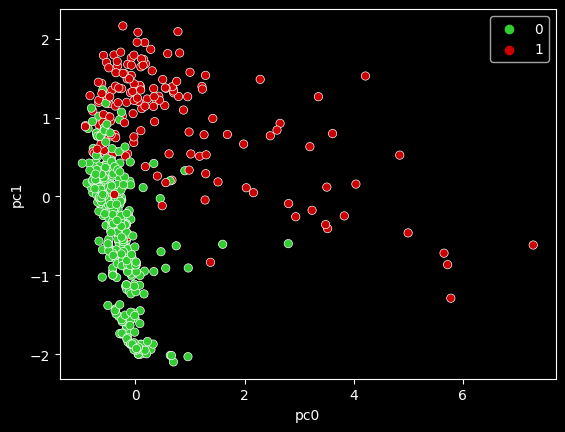

In [23]:
plt.style.use("dark_background")
sns.scatterplot(data = da, x= 'pc0', y = 'pc1', hue = ytr.values, palette = ["#33cc33", "#cc0000"])


<Axes: xlabel='pc0', ylabel='pc1'>

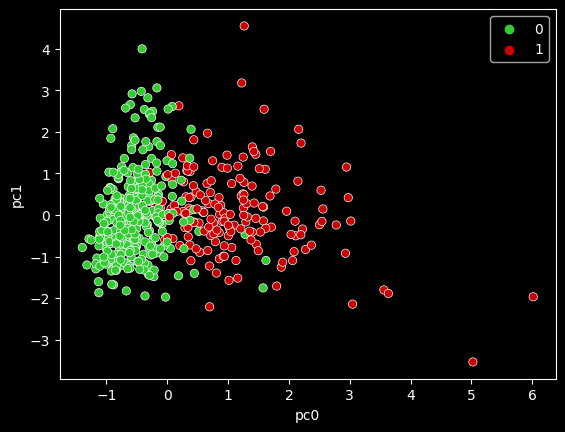

In [24]:
plt.style.use("dark_background")
sns.scatterplot(data = dx, x= 'pc0', y = 'pc1', hue = ytr.values, palette = ["#33cc33", "#cc0000"])

In [38]:

evals_result= {}
model_orig = xgb.XGBClassifier( n_estimators= 200,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = 70,
                           )


tr_X =   orig_train[best_features] # orig_train#
test_X = orig_test[best_features]  # orig_test
ytr = ytr #y_train
yte = yte #y_test


model_orig.fit(tr_X, ytr.values,                   # Xtr, ytr
          early_stopping_rounds = 50,   # 10% of n_estimators
          eval_set=[ (test_X, yte.values)],
          eval_metric = ['auc']    # binary classification problem
          )



[16:52:12] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[16:52:12] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[16:52:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[0]	validation_0-auc:0.94444
[16:52:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation_0-auc:0.97778
[16:52:13] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[2]	validation_0-auc:0.98687
[16:52:13] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[3]	validation_0-auc:0.98788
[16:52:13] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.98788
[16:52:13] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[5]	validation_0-auc:0.98788

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None, ...)

In [30]:

evals_result= {}
model_trans = xgb.XGBClassifier( n_estimators= 80,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = 70,
                           )


tr_X =   train_trans.iloc[:,5:]
test_X = test_trans.iloc[:,5:]
ytr = ytr #y_train
yte = yte #y_test


model_trans.fit(tr_X, ytr.values,                   # Xtr, ytr
          early_stopping_rounds = 10,   # 10% of n_estimators
          eval_set=[ (test_X, yte.values)],
          eval_metric = ['auc']    # binary classification problem
          )



[16:42:33] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[16:42:33] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[16:42:33] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.95556
[16:42:33] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=5
[1]	validation_0-auc:0.98889
[16:42:33] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.98788
[16:42:33] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.98788
[16:42:33] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.98788
[16:42:33] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.98788

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=80, n_jobs=None, num_parallel_tree=None, ...)